# `MonotonicSplineEpistasisCauchyLikelihood` model
Simulates some variants and analyzes them under the `globalepistasis.MonotonicSplineEpistasisCauchyLikelihood` model.

This notebook is designed as a test, not for user documentation--and it uses some private methods that should not be used in real analyses.

## Set up
Import Python modules:

In [1]:
import cProfile
import math
import pstats
import random
import tempfile
import time
import warnings

import pandas as pd

from plotnine import *

import scipy

import dms_variants.binarymap
import dms_variants.globalepistasis
import dms_variants.codonvarianttable
import dms_variants.plotnine_themes
import dms_variants.simulate
from dms_variants.constants import CBPALETTE, CODONS_NOSTOP

Parameters for simulations:

In [2]:
seed = 1  # random number seed
genelength = 30  # gene length in codons
bclen = 16  # length of barcodes
libs = ['lib_1', 'lib_2']  # distinct libraries of gene
variants_per_lib = 500 * genelength  # variants per library
avgmuts = 2.5  # average codon mutations per variant
variant_error_rate = 0  # rate variants are mis-sequenced
depth = 1000 * variants_per_lib  # per-sample sequencing depth
lib_uniformity = 5  # uniformity of library pre-selection
noise = 0.0  # non-statistical noise in selections
bottlenecks = {  # bottlenecks from pre- to post-selection
        'loose_bottle': variants_per_lib * 1000,
        }

Seed random number generators:

In [3]:
random.seed(seed)
scipy.random.seed(seed)

Suppress warnings that clutter output:

In [4]:
warnings.simplefilter('ignore')

Set plotnine theme:

In [5]:
theme_set(dms_variants.plotnine_themes.theme_graygrid())

## Simulate variants
Simulate wildtype gene sequence:

In [6]:
geneseq = ''.join(random.choices(CODONS_NOSTOP, k=genelength))
print(f"Wildtype gene of {genelength} codons:\n{geneseq}")

Wildtype gene of 30 codons:
AGATCCGTGATTCTGCGTGCTTACACCAACTCACGGGTGAAACGTGTAATCTTATGCAACAACGACTTACCTATCCGCAACATCCGGCTG


Simulate a `CodonVariantTable`:

In [7]:
variants = dms_variants.simulate.simulate_CodonVariantTable(
                geneseq=geneseq,
                bclen=bclen,
                library_specs={lib: {'avgmuts': avgmuts,
                                     'nvariants': variants_per_lib}
                               for lib in libs},
                seed=seed,
                )

Number of amino-acid mutations per variant in library:

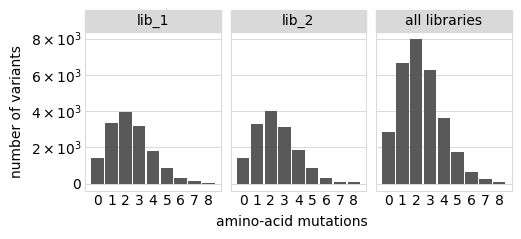

In [8]:
p = variants.plotNumMutsHistogram('aa', samples=None, max_muts=8)
p = p + theme(panel_grid_major_x=element_blank())  # no vertical grid lines
_ = p.draw()

## Simulate variant counts
We will simulate using a `SigmoidPhenotypeSimulator`:

In [9]:
phenosimulator = dms_variants.simulate.SigmoidPhenotypeSimulator(
                    geneseq,
                    seed=seed,
                    )

Plot relationship between simulated and observed phenotypes:

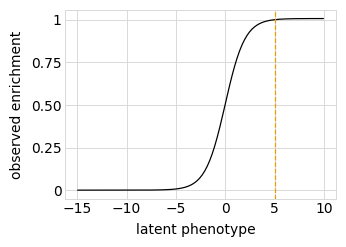

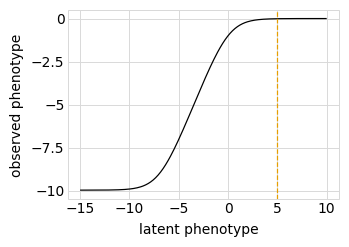

In [10]:
for value in ['enrichment', 'phenotype']:
    p = phenosimulator.plotLatentVsObserved(value)
    _ = p.draw()

Plot latent and observed phenotypes of all single amino-acid mutants:

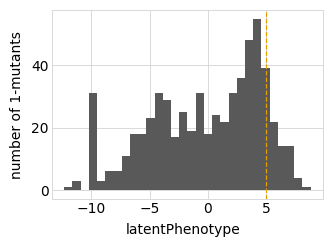

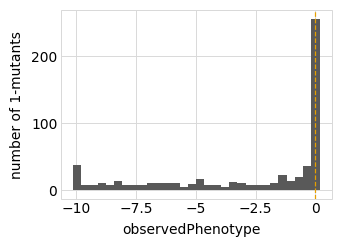

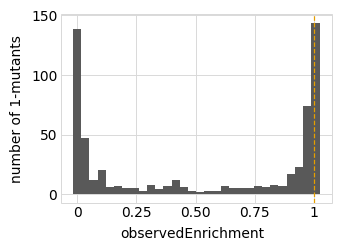

In [11]:
for value in ['latentPhenotype', 'observedPhenotype', 'observedEnrichment']:
    p = phenosimulator.plotMutsHistogram(value)
    _ = p.draw()

Now we simulate the counts according to the observed phenotype:

In [12]:
counts = dms_variants.simulate.simulateSampleCounts(
            variants=variants,
            phenotype_func=phenosimulator.observedEnrichment,
            variant_error_rate=variant_error_rate,
            pre_sample={'total_count': depth,
                        'uniformity': lib_uniformity},
            pre_sample_name='pre-selection',
            post_samples={name: {'noise': noise,
                                 'total_count': depth,
                                 'bottleneck': bottle}
                          for name, bottle in bottlenecks.items()},
            seed=seed,
            )

Add the counts to the variant table:

In [13]:
variants.add_sample_counts_df(counts)

Confirm expected selection on mutations:

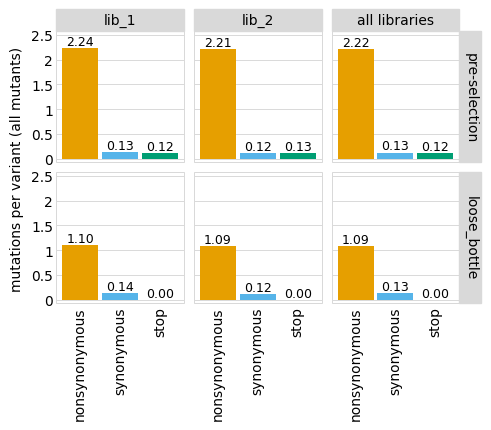

In [14]:
p = variants.plotNumCodonMutsByType('all')
p = p + theme(panel_grid_major_x=element_blank())  # no vertical grid lines
_ = p.draw()

In [15]:
variants.numCodonMutsByType('all')

,library,sample,mutation_type,num_muts_count,count,number
0,lib_1,pre-selection,nonsynonymous,33525161,15000000,2.235011
1,lib_1,pre-selection,synonymous,1990779,15000000,0.132719
2,lib_1,pre-selection,stop,1853645,15000000,0.123576
3,lib_1,loose_bottle,nonsynonymous,16451166,15000000,1.096744
4,lib_1,loose_bottle,synonymous,2097042,15000000,0.139803
5,lib_1,loose_bottle,stop,6264,15000000,0.000418
6,lib_2,pre-selection,nonsynonymous,33135875,15000000,2.209058
7,lib_2,pre-selection,synonymous,1858082,15000000,0.123872
8,lib_2,pre-selection,stop,1895505,15000000,0.126367
9,lib_2,loose_bottle,nonsynonymous,16293456,15000000,1.086230


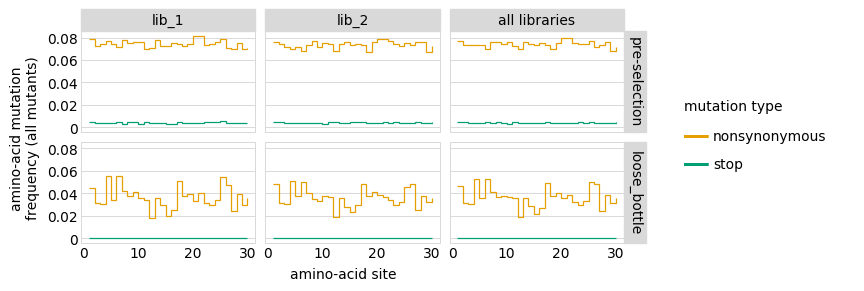

In [16]:
p = variants.plotMutFreqs('all', 'aa')
p = p + theme(panel_grid_major_x=element_blank())  # no vertical grid lines
_ = p.draw()

## Get functional scores
Get the functional scores:

In [17]:
func_scores = variants.func_scores('pre-selection', libraries=variants.libraries)

Classify the functional scores:

In [18]:
func_scores = variants.classifyVariants(func_scores)

Use `plotnine` to plot distribution of functional scores:

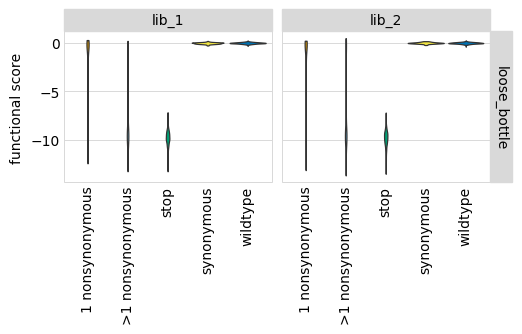

In [19]:
p = (
    ggplot(func_scores, aes('variant_class', 'func_score')) +
    geom_violin(aes(fill='variant_class')) +
    ylab('functional score') +
    xlab('') +
    facet_grid('post_sample ~ library') +
    theme(figure_size=(2.75 * len(libs),
                       2 * len(bottlenecks)),
          axis_text_x=element_text(angle=90),
          panel_grid_major_x=element_blank(),  # no vertical grid lines
          ) +
    scale_fill_manual(values=CBPALETTE[1 :], guide=False)
    )
_ = p.draw()

## Initialize model

Make a binary map for the variants:

In [20]:
binarymap = dms_variants.binarymap.BinaryMap(func_scores)
binarymap.func_scores_var = None
print(f"Length of binary map is {binarymap.binarylength}")

Length of binary map is 600


Now initialize the model:

In [21]:
model = dms_variants.globalepistasis.MonotonicSplineEpistasisCauchyLikelihood(binarymap)

Look at some model attributes:

In [22]:
model.nparams

608

In [23]:
model.likelihood_calc_params_dict

{'scale_parameter': 1.0}

In [24]:
round(model.loglik)

-149210.0

In [25]:
model.latent_phenotype_wt()

0.0

In [26]:
for key, val in model.epistasis_func_params_dict.items():
    print(f"{key}: {round(val, 2)}")

c_alpha: -13.66
alpha_1: 2.83
alpha_2: 2.83
alpha_3: 2.83
alpha_4: 2.83
alpha_5: 2.83


Check the analytical gradient versus numerical approximation, and make sure the difference is small compared to total gradient:

In [27]:
err = scipy.optimize.check_grad(
            model._loglik_by_allparams,
            model._dloglik_by_allparams,
            model._allparams)
tot = math.sqrt(sum(model._dloglik_by_allparams(model._allparams)**2))
if err / tot > 1e-5:
    raise ValueError(f"Numerical and analytical gradients differ: {err}, {tot}, {err / tot}")

## Fit model
Perform initial least squares optimization followed by rescaling latent effects (normally this is actually performed by the `fit` method):

In [28]:
model._fit_latent_leastsquares()
model._prescale_params()

Re-check the gradients:

In [29]:
err = scipy.optimize.check_grad(
            model._loglik_by_allparams,
            model._dloglik_by_allparams,
            model._allparams)
tot = math.sqrt(sum(model._dloglik_by_allparams(model._allparams)**2))
if err / tot > 1e-3:
    raise ValueError(f"Numerical and analytical gradients differ: {err}, {tot}, {err / tot}")

Print model parameters after this "partial" fitting:

In [30]:
round(model.loglik)

-89969.0

In [31]:
for param, val in model.likelihood_calc_params_dict.items():
    print(f"{param}: {val:.3f}")

scale_parameter: 2.423


In [32]:
round(model.latent_phenotype_wt(), 3)

0.935

Now fit the model by maximum likelihood, also profiling [as here](https://stackoverflow.com/a/1584468).


In [33]:
# NBVAL_IGNORE_OUTPUT
start = time.time()
profiler = cProfile.Profile()
optres = profiler.runcall(model.fit)
print(f"Fitting took {time.time() - start:.3f} seconds")
print(f"Iterations: {optres.nit}.\n"
      f"Function evaluations: {optres.nfev}\n"
      f"Termination message: {optres.message}")

Fitting took 75.654 seconds
Iterations: 1201.
Function evaluations: 1418
Termination message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


Look at some of the model parameters after optimization:

In [34]:
assert scipy.allclose(model.loglik,
                      -26287,
                      rtol=0.01), model.loglik

In [35]:
assert scipy.allclose(model.likelihood_calc_params_dict['scale_parameter'],
                      0.217284,
                      rtol=0.01,
                      atol=0.005,
                      ), model.likelihood_calc_params_dict['scale_parameter']

In [36]:
assert scipy.allclose(model.latent_phenotype_wt(), 0), model.latent_phenotype_wt()

In [37]:
assert scipy.allclose(model._mesh, 
                      scipy.array([-7.699, -5.393, -3.087, -0.781]),
                      atol=0.5,
                      rtol=0.05), model._mesh

In [38]:
assert scipy.allclose(model.alpha_ms(),
                      scipy.array([0, 0, 0, 0, 9.77]),
                      atol=0.1,
                      rtol=0.01), model.alpha_ms()

In [39]:
assert scipy.allclose(model.c_alpha(),
                      -9.81,
                      atol=0.1,
                      rtol=0.01), model.c_alpha()

Plot correlation of actual functional scores with latent and observed phenotypes:


Correlation for observed:
R = 0.99, P = 0


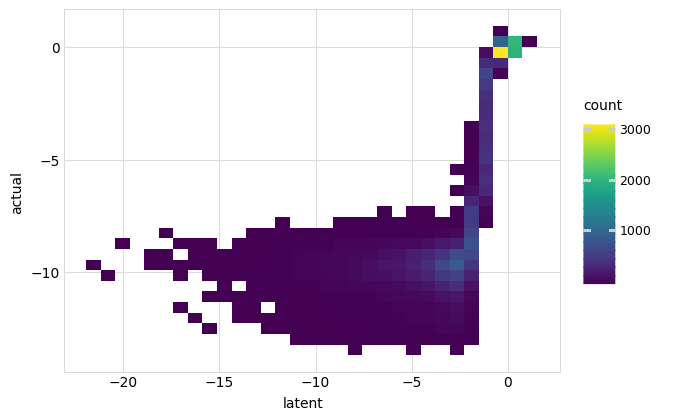

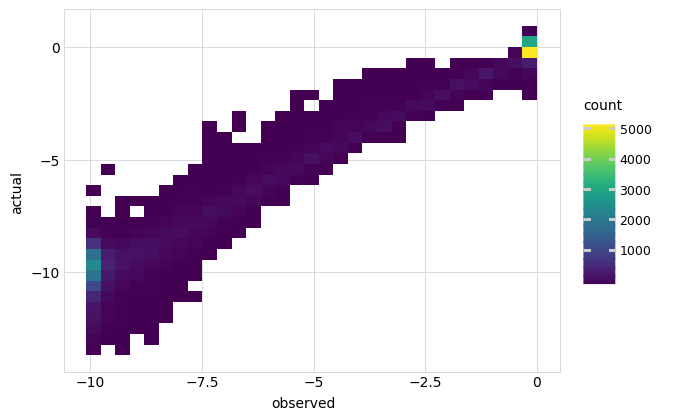

In [40]:
df = pd.DataFrame({'actual': binarymap.func_scores,
                   'latent': model.phenotypes_frombinary(
                                    binarymap.binary_variants, 'latent'),
                   'observed': model.phenotypes_frombinary(
                                    binarymap.binary_variants, 'observed'),
                   })

for phenotype in ['latent', 'observed']:
    _ = (ggplot(df, aes(phenotype, 'actual')) +
         geom_bin2d()
         ).draw()
    
    if phenotype == 'observed':
        r, p = scipy.stats.pearsonr(
            binarymap.func_scores,
                model.phenotypes_frombinary(binarymap.binary_variants,
                                                   phenotype)
            )
        print(f"\nCorrelation for {phenotype}:\nR = {r:.2f}, P = {p:.2g}")

Plot latent versus observed phenotypes:

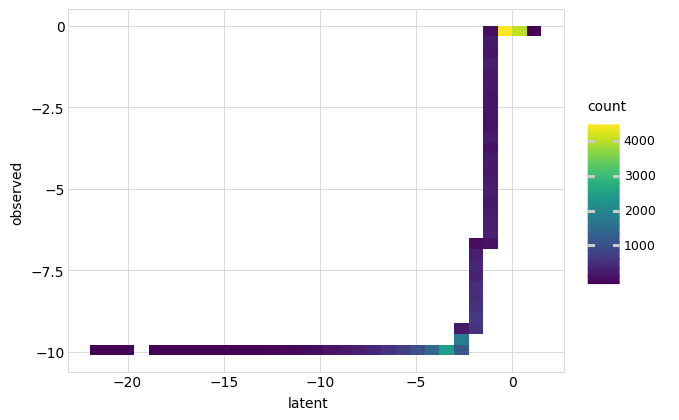

In [41]:
_ = (ggplot(df, aes('latent', 'observed')) +
     geom_bin2d()
     ).draw()

Look at profiling results:

In [42]:
# NBVAL_IGNORE_OUTPUT
with tempfile.NamedTemporaryFile('w') as f:
    profiler.dump_stats(f.name)
    f.flush()
    stats = pstats.Stats(f.name).strip_dirs()
for stat in ['cumtime', 'tottime']:
    print(stats.sort_stats(stat).print_stats(20))

Sat Nov  9 06:09:01 2019    /tmp/tmpfa261uag

         13976485 function calls (12649531 primitive calls) in 75.648 seconds

   Ordered by: cumulative time
   List reduced from 346 to 20 due to restriction <20>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.001    0.001   75.648   75.648 globalepistasis.py:747(fit)
        1    0.001    0.001   75.557   75.557 _minimize.py:42(minimize)
        1    0.252    0.252   75.556   75.556 lbfgsb.py:211(_minimize_lbfgsb)
     1418    0.010    0.000   75.297    0.053 lbfgsb.py:284(func_and_grad)
679609/4255    1.218    0.000   56.449    0.013 methodtools.py:31(__call__)
     4255    1.945    0.000   56.425    0.013 ispline.py:247(_calculate_Itotal_or_dItotal)
    28330    3.834    0.000   50.790    0.002 ispline.py:673(_calculate_I_or_dI)
     1418    0.005    0.000   44.125    0.031 optimize.py:324(function_wrapper)
     1418    0.015    0.000   44.120    0.031 globalepistasis.py:793(_loglik_by_allparams

## Examine single mutants
Correlation of predicted and actual predicted latent effects.
Get a data frame of the latent effects of all single mutations:

In [43]:
singles_df = model.latent_effects_df

Add the true latent effects from the simulator:

In [44]:
singles_df = (
    singles_df
    .rename(columns={'mutation': 'aa_substitutions'})
    .assign(true_latent_effect=lambda x: x['aa_substitutions'].map(phenosimulator.muteffects))
    )

Now add the predicted and true latent and observed phenotypes:

In [45]:
singles_df = model.add_phenotypes_to_df(singles_df)

singles_df = (
    singles_df
    .assign(true_latent_phenotype=lambda x: x['aa_substitutions']
                                .map(phenosimulator.latentPhenotype),
            true_enrichment=lambda x: x['aa_substitutions']
                                .map(phenosimulator.observedEnrichment),
            true_observed_phenotype=lambda x: x['aa_substitutions']
                                .map(phenosimulator.observedPhenotype),
            enrichment=lambda x: model.enrichments(
                                x['observed_phenotype'])
            )
    )

Correlations among the observed quantities:

In [46]:
print(
 singles_df
 [[c for c in singles_df.columns if 'latent' not in c]]
 .corr()
 .to_csv(float_format='%.1f')
 )

,observed_phenotype,true_enrichment,true_observed_phenotype,enrichment
observed_phenotype,1.0,0.9,1.0,0.9
true_enrichment,0.9,1.0,0.9,1.0
true_observed_phenotype,1.0,0.9,1.0,0.9
enrichment,0.9,1.0,0.9,1.0



## Examine all variants used for fitting
Look at correlation among all the variants used to fit the model:

In [47]:
variants_df = model.phenotypes_df

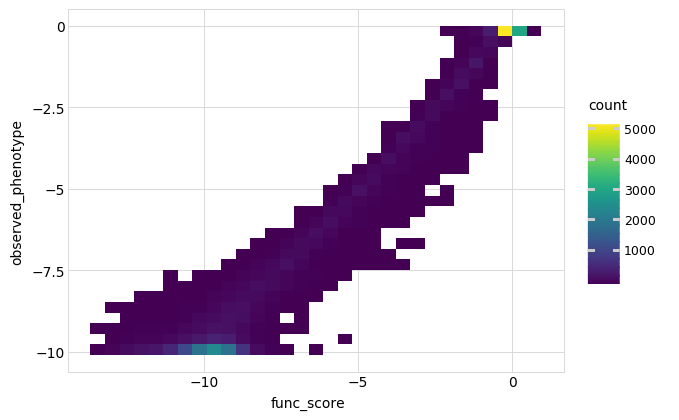

In [48]:
_ = (ggplot(variants_df, aes('func_score', 'observed_phenotype')) + 
     geom_bin2d()
     ).draw()

In [49]:
print(
 variants_df
 [['func_score', 'latent_phenotype', 'observed_phenotype']]
 .corr()
 .to_csv(float_format='%.1f')
 )

,func_score,latent_phenotype,observed_phenotype
func_score,1.0,0.7,1.0
latent_phenotype,0.7,1.0,0.7
observed_phenotype,1.0,0.7,1.0

